# Text Clustering

- [https://towardsdatascience.com/clustering-product-names-with-python-part-1](https://towardsdatascience.com/clustering-product-names-with-python-part-1-f9418f8705c8?gi=3b31358c9b1a)
- [https://towardsdatascience.com/clustering-product-names-with-python-part-2](https://towardsdatascience.com/clustering-product-names-with-python-part-2-648cc54ca2ac)

In [ ]:
""" 
cd 05text_clustering
jupyter nbconvert --to markdown text-clustering.ipynb --output README.md

 """

## Prepossessing

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
# import nltk
# nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

#Load data set
df = pd.read_csv('Food Details.csv')
df.columns

Index(['Public Food Key', 'Food Profile ID', 'Derivation', 'Food Name',
       'Food Description', 'Sampling Details', 'Nitrogen Factor', 'Fat Factor',
       'Specific Gravity', 'Analysed Portion', 'Unanalysed Portion',
       'Classification', 'Classification Name'],
      dtype='object')

In [3]:
text1 = df['Food Name']
#Remove stopwords, punctuation and numbers
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]

In [4]:
#Stem and make lower case
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

text3 = pd.Series([stemSentence(x) for x in text2])

In [5]:
#Remove colours
colors = list(webcolors.CSS3_NAMES_TO_HEX)
colors = [stemSentence(x) for x in colors if x not in ('bisque','blanchedalmond','chocolate','honeydew','lime',
                                         'olive','orange','plum','salmon','tomato','wheat')]
text4 = [' '.join([x for x in string.split() if x not in colors]) for string in text3]

In [8]:
text4[:2]

['cardamom seed dri ground', 'cinnamon dri ground']

In [7]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text4)

In [6]:
#TF-IDF (n-gram level)
vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
X_ntf = vectorizer_ntf.fit_transform(text4)

## LDA

c:\Users\soiko\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


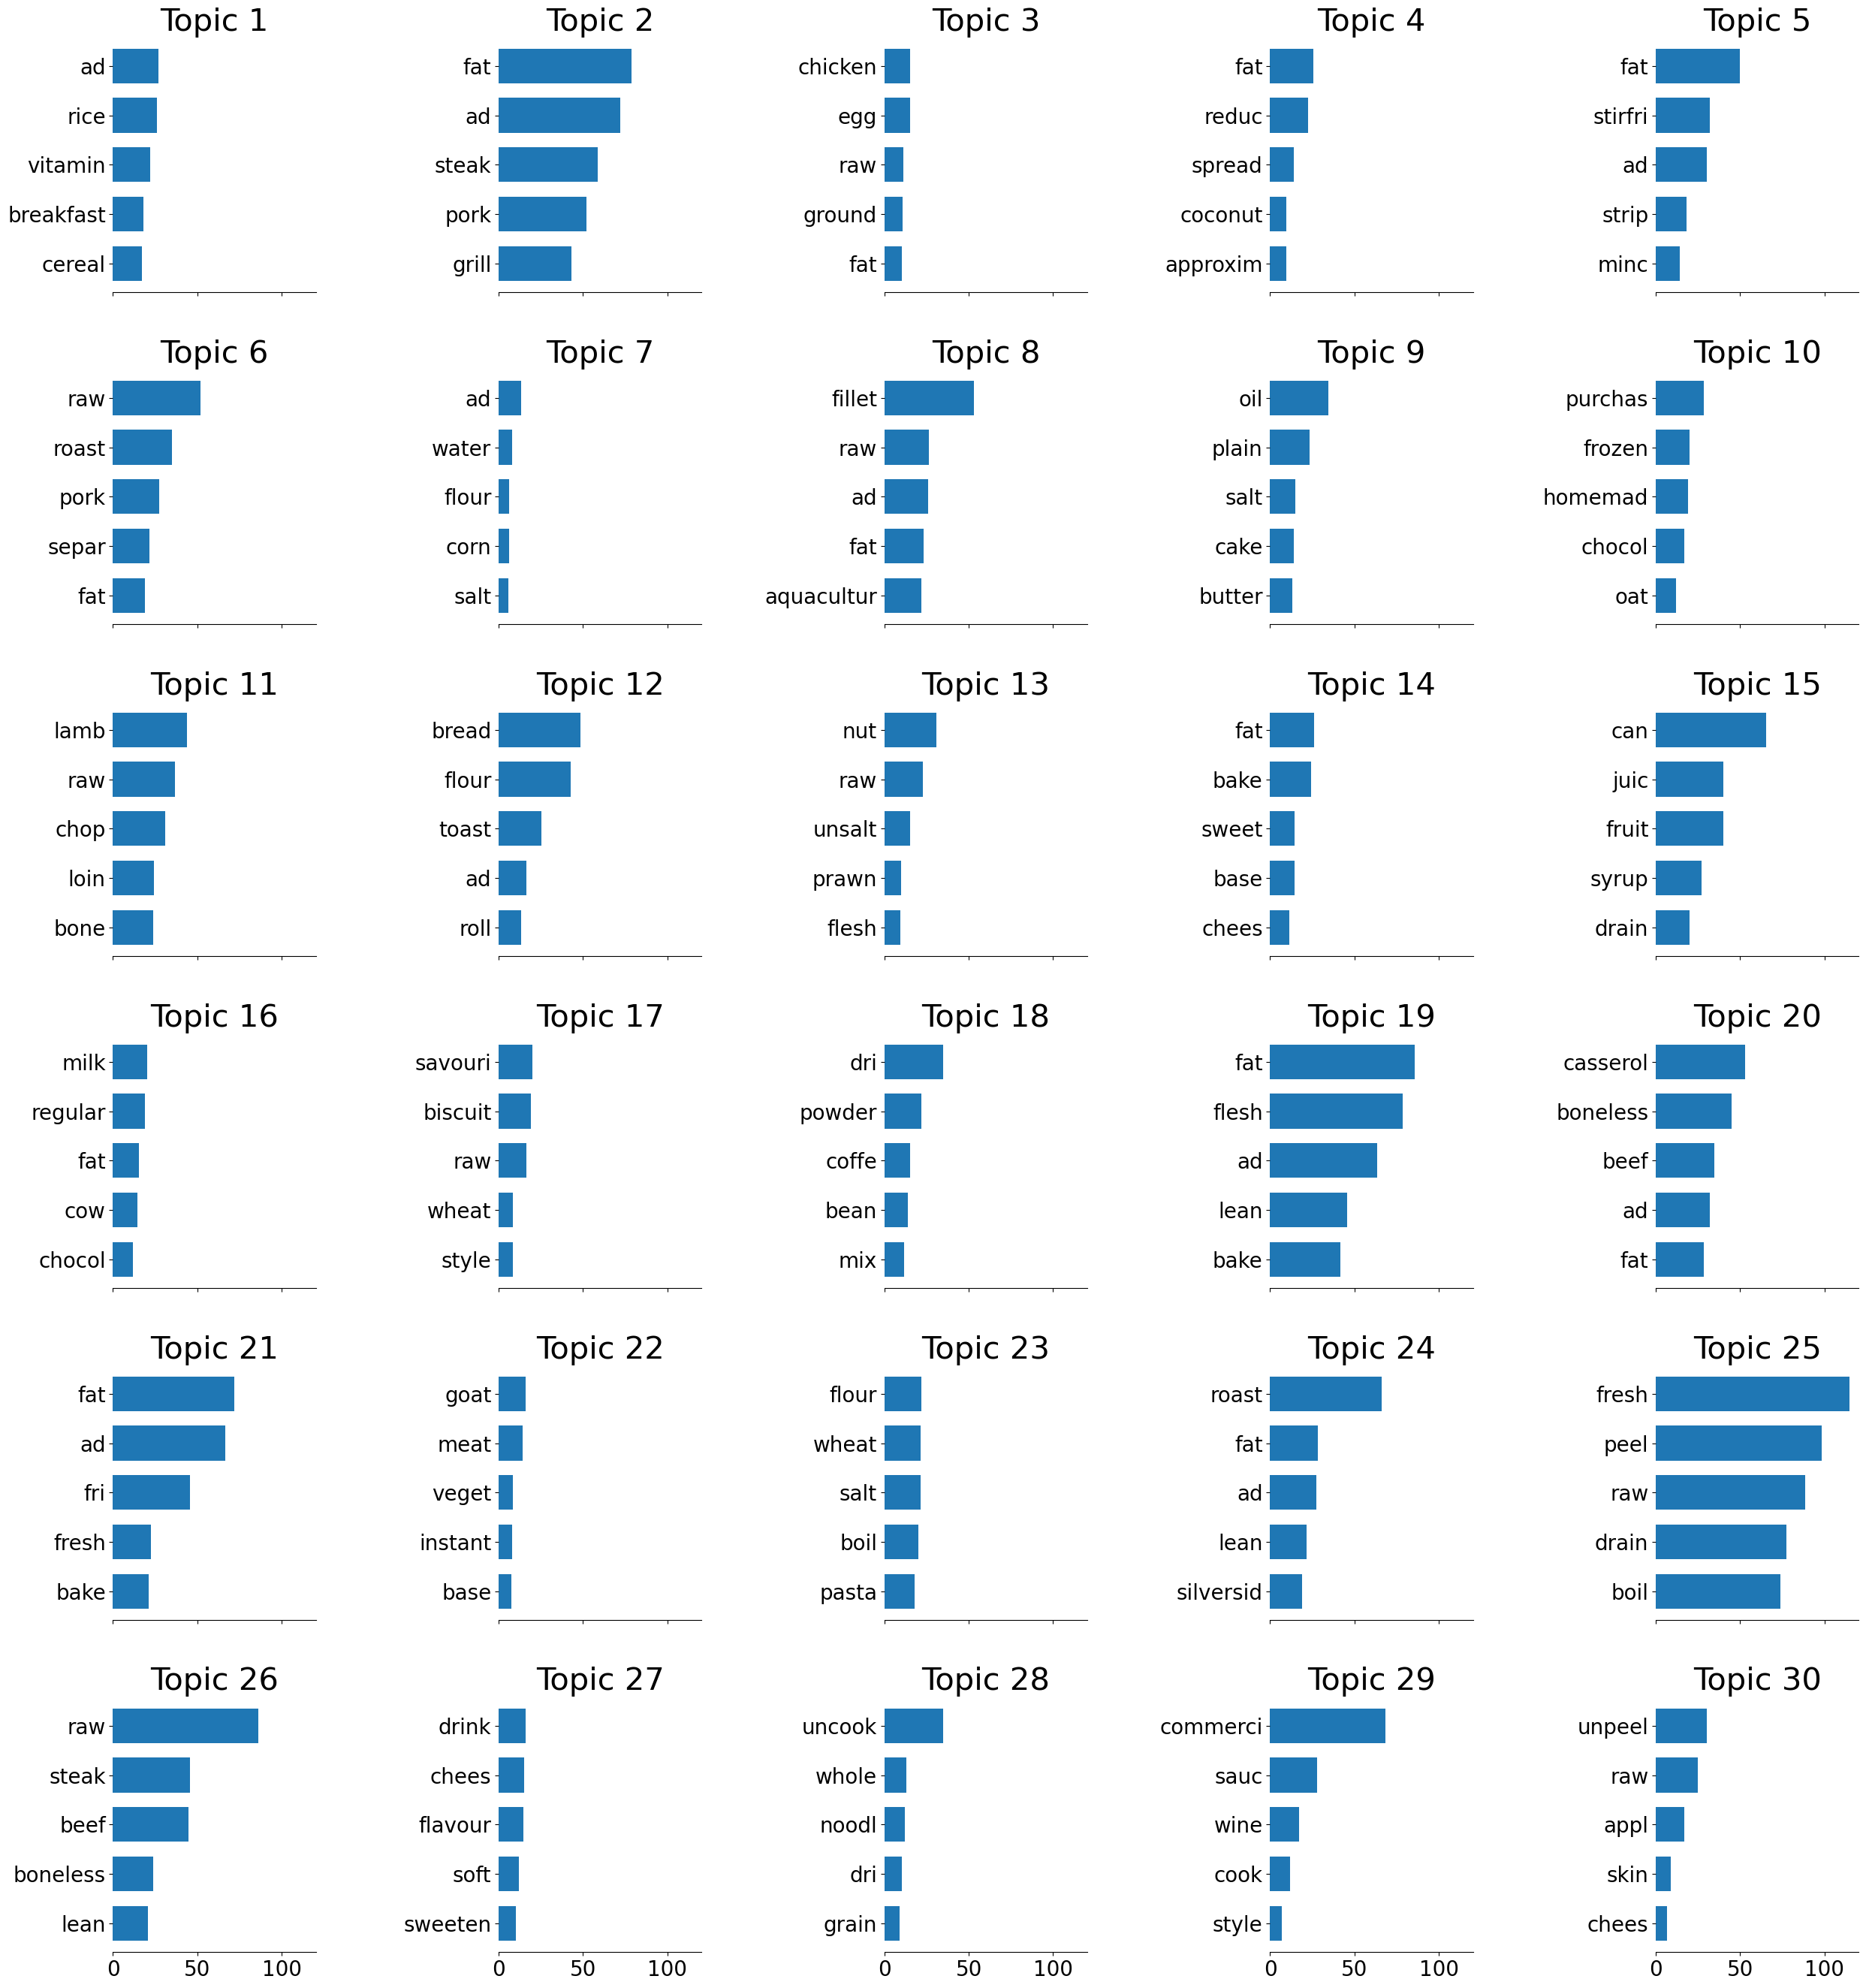

In [7]:
#LDA
lda = LatentDirichletAllocation(n_components=30, learning_decay=0.9)
X_lda = lda.fit(X_cv)

#Plot topics function. Code from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
#Show topics
n_top_words = 5
feature_names = vectorizer_cv.get_feature_names()
plot_top_words(X_lda, feature_names, n_top_words, '')

## K-means clustering

In [8]:
np.arange(100,900,100)

array([100, 200, 300, 400, 500, 600, 700, 800])

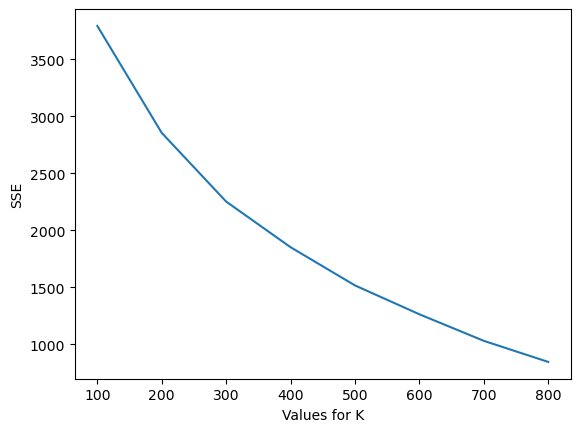

In [9]:
sse={}
for k in np.arange(100,900,100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

Creating the clusters
Let’s start here and test K=200.

In [9]:
# vectorizer_cv.get_feature_names_out()

In [11]:
!pip install -U threadpoolctl


In [25]:
#Create 200 clusters
kmeans = KMeans(n_clusters=200)
kmeans.fit(X_cv)
result = pd.concat([text1,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X_cv)

c:\Users\soiko\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
result[["Food Name","cluster"]]

,Food Name,cluster
0,"Cardamom seed, dried, ground",101
1,"Cinnamon, dried, ground",101
2,"Cloves, dried, ground",101
3,"Coriander seed, dried, ground",101
4,"Cumin (cummin) seed, dried, ground",101
...,...,...
1612,"Yoghurt, coconut based, flavoured",59
1613,"Yoghurt, flavoured, high fat (approx 5%)",102
1614,"Yoghurt, flavoured, low fat (0.2%), intense sw...",102
1615,"Yoghurt, flavoured, low fat (approx 2%)",102


In [61]:
#Label each cluster with the word(s) that all of its food names have in common
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Food Name' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')
result_labelled[["Food Name","cluster","label"]]

,Food Name,cluster,label
0,"Cardamom seed, dried, ground",101,dri
1,"Cinnamon, dried, ground",101,dri
2,"Cloves, dried, ground",101,dri
3,"Coriander seed, dried, ground",101,dri
4,"Cumin (cummin) seed, dried, ground",101,dri
...,...,...,...
1612,"Yoghurt, coconut based, flavoured",59,
1613,"Yoghurt, flavoured, high fat (approx 5%)",102,fat flavour yoghurt
1614,"Yoghurt, flavoured, low fat (0.2%), intense sw...",102,fat flavour yoghurt
1615,"Yoghurt, flavoured, low fat (approx 2%)",102,fat flavour yoghurt


## Treemap Charts with plotly


- [https://plotly.com/python/treemaps/](https://plotly.com/python/treemaps/)

In [108]:
data = [{'topic': "document","cluster":0, 'phrase': "document extract", 'score': 5},
        {'topic': "document","cluster":0, 'phrase': "document extraction", 'score': 4},
				{'topic': "document", "cluster":0,'phrase': "document topic", 'score': 3},
				{'topic': "document","cluster":0, 'phrase': "document model", 'score': 2},
				{'topic': "document", "cluster":0,'phrase': "document text", 'score': 1},
				{'topic': "similarity","cluster":1, 'phrase': "cosine similarity", 'score': 3},
				{'topic': "similarity","cluster":1, 'phrase': "vector similarity", 'score': 2},
				{'topic': "similarity","cluster":1, 'phrase': "text similarity", 'score': 1},

				]

# Creates DataFrame.
df = pd.DataFrame(data)
df

,topic,cluster,phrase,score
0,document,0,document extract,5
1,document,0,document extraction,4
2,document,0,document topic,3
3,document,0,document model,2
4,document,0,document text,1
5,similarity,1,cosine similarity,3
6,similarity,1,vector similarity,2
7,similarity,1,text similarity,1


In [109]:
fig = px.treemap(df, path=['topic',  'phrase'], values='score')
fig.show()